<a href="https://colab.research.google.com/github/triatebr/aprenda-python/blob/master/Florest_TDCSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![logos](https://img.freepik.com/free-vector/telemarketing-background-design_1212-238.jpg?size=338&ext=jpg)

In [0]:
#importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [3]:

from google.colab import files
uploaded = files.upload()

Saving bank-full.csv to bank-full (2).csv


**Dados utilizados**

Para o exempçlo de árvore de descisão iremo utilizar um [dataset de Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Ele demonstra valores de campanha de telemarketing de banco portugues. O objetivo e prever de cliente assinará um termo de deposito.

In [4]:
dados = pd.read_csv('bank-full.csv', delimiter=';')
dados.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
#verificar as colunas utlizadas
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [6]:
#Nº de linhas e colunas
dados.shape

(45211, 17)

![logos](https://psucd8.files.wordpress.com/2011/10/outlierscatterplot_10001.gif)

**Processo de detecção de OUTLIERS**

Em estatística, **outlier** , valor aberrante ou valor atípico, é uma observação que apresenta <p> um grande afastamento das demais da série (que está "fora" dela), ou que é inconsistente. <p>A existência de outliers implica, tipicamente, em prejuízos a interpretação dos resultados dos **testes estatísticos** aplicados às amostras.

In [0]:
#Lista com as colunas numéricas que não são necessariamente contínus
numerical_columns = [col for col in dados.columns if (dados[col].dtype=='int64' or dados[col].dtype=='float64')]

In [8]:
numerical_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [9]:
dados[numerical_columns].describe().loc[['min', 'max', 'mean', '50%'],:]

,age,balance,day,duration,campaign,pdays,previous
min,18.00000,-8019.000000,1.000000,0.00000,1.000000,-1.000000,0.000000
max,95.00000,102127.000000,31.000000,4918.00000,63.000000,871.000000,275.000000
mean,40.93621,1362.272058,15.806419,258.16308,2.763841,40.197828,0.580323
50%,39.00000,448.000000,16.000000,180.00000,2.000000,-1.000000,0.000000


Repara-se que há no **Balance** um valor de '-8019' ! Estranho neh<p>
    Esses valor pode atrapalhar todo o processo de **aprendizado de máquina**

In [10]:
dados[dados['balance'] == dados['balance'].min ()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12909,26,blue-collar,single,secondary,yes,-8019,no,yes,cellular,7,jul,299,3,-1,0,unknown,no


Vamos apagar o registro '12909' do conjunto de dados.

In [0]:
dados.drop(dados.index[12909], inplace=True)

![logos](https://mktes.files.wordpress.com/2014/09/curso-de-web-design-e28093-microcamp-curitiba-centro-aponta-as-vantagens-da-segmentac3a7c3a3o-de-mercado.jpg?)

Após a importação dos dados (.csv), iremos dividir o arquivo em 2 partes.<p>
    Pois assim, deixaremos um montante de registros para ser utilizado no modelo de **IA** após o término.<p>
        Ao todo temos 45211 registros, para o desenvolvimento da IA, usaremos 30000 e deixaremos o restante para a 2ª fase do processo
        

In [0]:
#vamos começar embaralhando o conjunto de dados, pois ele pode estar ordenado de alguma forma
dados = dados.sample(frac=1)

In [13]:
#1ª segmentação 
dados = dados.head(30000)
dados.shape

(30000, 17)

In [14]:
#2ª segmentação
df = dados.tail(25211)
df.shape

(25211, 17)

Usaremos para o desenvolvimento do modelo de **IA** o conjunto 'dados'<p>
    O dataframe 'df' será utilizado em 2º momento

Como podemos perceber os dados estão distribuidos de varias maneiras, temos variaveis categoricas, representadas como objetos e variaveis numericas. Varios dados são desconhecidos, porém estão salvos como 'unknown'.

**análise exploratoria**

Antes de prevemos os valores vamos fazer uma análise exploratoria, vamos verificar qual idade e qual escolaridade tem maior chance de fechar o deposito.

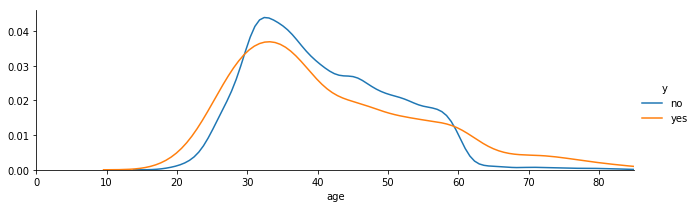

In [15]:
idade= sns.FacetGrid(dados, hue="y", aspect=3);
idade.map(sns.kdeplot, "age").add_legend();
idade.set(xlim=(0, 85));

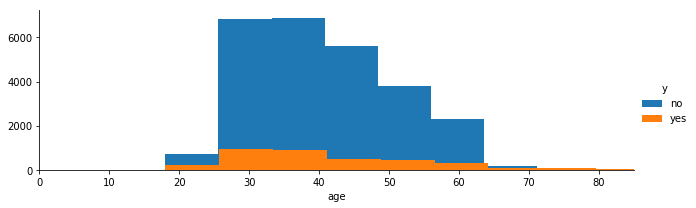

In [16]:
idade= sns.FacetGrid(dados, hue="y", aspect=3);
idade.map(plt.hist, "age").add_legend();
idade.set(xlim=(0, 85));

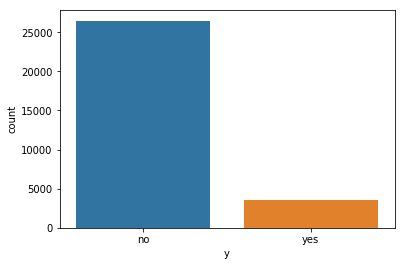

In [17]:
sns.countplot(dados['y'])

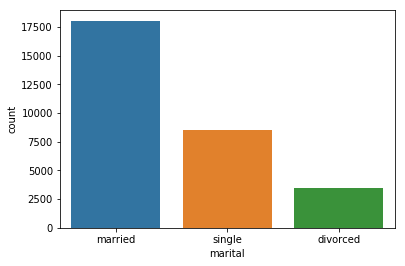

In [18]:
sns.countplot(dados['marital'])

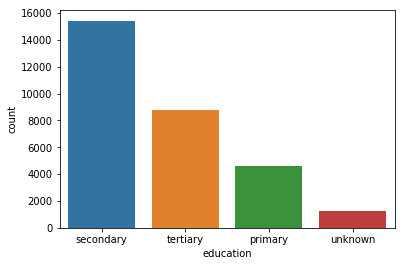

In [19]:
sns.countplot(dados['education'])

**Tratamento dos dados**

Porém para podermos utilizar os dados em algum algoritmo de aprendizado  precisamos que todos os valores sejam numericos, assim precisamos converter as colunas que são object.

Existem maneiras de fazermos isto com o sklearn ou com o pandas.
Vamos mostrar as duas:

- **Pandas:** Com o pandas convertemos a coluna para category, apos isto podemos fazer a função cat.codes. 
- **Sklearn:** Temos que utilizar a classe LabelEnconder, ela funciona como a classe de normalização.

In [0]:
education = dados['education']

In [16]:
education.head()

4508     secondary
1478     secondary
27842    secondary
21422      primary
6986      tertiary
Name: education, dtype: object

In [17]:
#Pandas
#Convertendo os dados para categorico
educationConv = education.astype('category')

# pegando o valores de cada categoria
educationConv = educationConv.cat.codes
educationConv[:5]

4508     1
1478     1
27842    1
21422    0
6986     2
dtype: int8

In [18]:
education.head()

4508     secondary
1478     secondary
27842    secondary
21422      primary
6986      tertiary
Name: education, dtype: object

In [19]:
#Sklearn
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
educationConv2 = label.fit_transform(education)
educationConv2[:5]

array([1, 1, 1, 0, 2])

Agora vamos usar um loop para podermos fazer a conversão de todos os dados do dataframe 

In [0]:
for coluna in dados:
    if dados[coluna].dtype == object:
        dados[coluna] = dados[coluna].astype('category').cat.codes

Nota-se como o dataframe ficou após a conversão dos **dados** !

In [21]:
dados.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4508,35,2,1,1,0,1163,1,0,2,20,8,284,1,-1,0,3,0
1478,32,0,2,1,0,184,1,0,2,8,8,230,4,-1,0,3,0
27842,55,1,1,1,0,93,0,1,0,28,4,111,1,-1,0,3,0
21422,58,5,1,0,0,1241,0,0,0,18,1,194,2,-1,0,3,1
6986,24,7,2,2,0,1385,1,0,2,28,8,1277,2,-1,0,3,0


**Separando dados**

Com os dados convertidos vamos separa X e y, e em treino e teste.

In [0]:
dadosY1 = dados[dados['y']== 1]
dadosY2 = dados[dados['y']== 0]

In [0]:
dadosY2 = dadosY2.sample(len(dadosY1))

In [0]:
dados2 = pd.concat([dadosY1,dadosY2])

Apaga-se a coluna **y** (coluna alvo)

In [0]:
y = dados.y
x = dados.drop('y',axis=1) 

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#Optamos por destinar 30% dos dados para treino
np.random.seed(100)
xTreino,xTeste,yTreino,yTeste = train_test_split(x,y, test_size=0.3)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf = RandomForestClassifier(max_depth=4)
rf.fit(xTreino,yTreino)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
#NÃO RODAR
#Predizendo dados 
preditos = rf.predict(xTeste)
#Verificando modelo
from sklearn.metrics import classification_report
print(classification_report(preditos,yTeste))

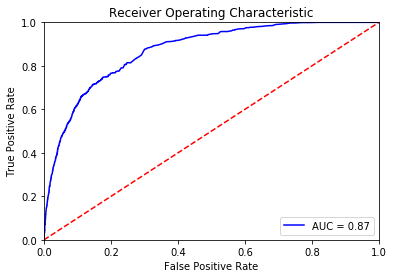

In [30]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(xTeste)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(yTeste, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
print ("\nAcurácia de classificação = "+str(100*roc_auc)+"%\n")


Acurácia de classificação = 87.10748525239417%



![logos](https://cdn4.iconfinder.com/data/icons/robotics-and-artificial-intelligence/512/2-512.png)

Agora abordaremos a 2ª parte do conjunto de dados separada lá no começo<p>
    Chamamos de "**df**"<p>
        Realizaremos todo o tratamento de dados novamente para os mesmos<p>
            Porém antes realizaremos uma análise dos dados

In [32]:
df.shape

(25211, 17)

In [33]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4562,33,services,married,unknown,no,89,yes,no,unknown,20,may,341,1,-1,0,unknown,no
8341,42,blue-collar,married,secondary,no,130,no,no,unknown,2,jun,180,3,-1,0,unknown,no
1563,41,services,married,secondary,no,639,yes,no,unknown,8,may,1187,2,-1,0,unknown,no
37234,45,management,divorced,tertiary,no,2813,yes,no,cellular,13,may,43,1,-1,0,unknown,no
42340,53,technician,married,secondary,no,163,yes,yes,cellular,24,nov,108,1,-1,0,unknown,no


In [0]:
education = df['education']

In [35]:
education.head()

4562       unknown
8341     secondary
1563     secondary
37234     tertiary
42340    secondary
Name: education, dtype: object

In [36]:
#dessa vez usaremos somente o Sklearn
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
educationConv2 = label.fit_transform(education)
educationConv2[:5]

array([3, 1, 1, 2, 1])

In [0]:
for coluna in df:
    if df[coluna].dtype == object:
        df[coluna] = df[coluna].astype('category').cat.codes

In [38]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4562,33,7,1,3,0,89,1,0,2,20,8,341,1,-1,0,3,0
8341,42,1,1,1,0,130,0,0,2,2,6,180,3,-1,0,3,0
1563,41,7,1,1,0,639,1,0,2,8,8,1187,2,-1,0,3,0
37234,45,4,0,2,0,2813,1,0,0,13,8,43,1,-1,0,3,0
42340,53,9,1,1,0,163,1,1,0,24,9,108,1,-1,0,3,0


In [0]:
xx = df.drop('y',axis=1)

In [40]:
xx.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
4562,33,7,1,3,0,89,1,0,2,20,8,341,1,-1,0,3
8341,42,1,1,1,0,130,0,0,2,2,6,180,3,-1,0,3
1563,41,7,1,1,0,639,1,0,2,8,8,1187,2,-1,0,3
37234,45,4,0,2,0,2813,1,0,0,13,8,43,1,-1,0,3
42340,53,9,1,1,0,163,1,1,0,24,9,108,1,-1,0,3


In [0]:
#Predizendo dados 
preditos = rf.predict(xx)
perc_resp = rf.predict_proba(xx)

In [42]:
preditos

array([0, 0, 0, ..., 0, 0, 1], dtype=int8)

In [43]:
perc_resp[:,0] #todas as linhas da 1ª coluna

array([0.95388693, 0.96298637, 0.60895   , ..., 0.89172665, 0.85589321,
       0.48707293])

In [44]:
perc_resp[:,1] #todas as linhas da 2ª coluna

array([0.04611307, 0.03701363, 0.39105   , ..., 0.10827335, 0.14410679,
       0.51292707])

In [0]:
xx['resp']=preditos

In [0]:
xx['perc_resp1'] =perc_resp[:,0]

In [0]:
xx['perc_resp2'] = perc_resp[:,1] 

In [48]:
xx.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,resp,perc_resp1,perc_resp2
4562,33,7,1,3,0,89,1,0,2,20,8,341,1,-1,0,3,0,0.953887,0.046113
8341,42,1,1,1,0,130,0,0,2,2,6,180,3,-1,0,3,0,0.962986,0.037014
1563,41,7,1,1,0,639,1,0,2,8,8,1187,2,-1,0,3,0,0.608950,0.391050
37234,45,4,0,2,0,2813,1,0,0,13,8,43,1,-1,0,3,0,0.952607,0.047393
42340,53,9,1,1,0,163,1,1,0,24,9,108,1,-1,0,3,0,0.956256,0.043744
